**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources: Soner Yıldırım, Bex T, Manuel Hupperich, Youssef Hosni and Piero Paialunga en www.towardsdatascience.com. Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# Time Series Analysis: LSTM

Long Short Term Memory or LSTM is a type of Neural Network, which was developed on the basis provided by the Recurrent Neural Networks, or RNN. The algorithms main usage falls into NLPs or Time Series, and the main idea behind it relates to processing the information they receive from the previous neuron and applying the activation function from scratch (as the CNN/RNN do), they actually divide the neuron into three main parts from which to set up the input from the next layer of neurons: Learn, Unlearn and Retain gate. The structure of the LSTM layer can be visualized in the image below:

![LSTM](https://miro.medium.com/max/700/0*RkFisWmsLWtGCByq.png)

#### Parameters for the LSTM
* PERCENTAGE = .98 #Split train/val and test set
* CALLBACK = .031 #Used to stop training the Network when the MAE from the validation set reached a perormance below 3.1%
* BATCH_SIZE = 20 #Number of samples that will be propagated through the network. I chose almost a trading month
* EPOCH = 50 #Settled to train the model
* WINDOW_LSTM = 30 #The window used for the input data
* PREDICTION_SCOPE = 0 #How many period to predict, being 0=1

In [1]:
import keras
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
#from keras.optimizers import SGD

In [2]:
Q = sm.datasets.co2.load_pandas().data
Q = Q.interpolate()
Q.head(10)

,co2
1958-03-29,316.10
1958-04-05,317.30
1958-04-12,317.60
1958-04-19,317.50
1958-04-26,316.40
1958-05-03,316.90
1958-05-10,317.20
1958-05-17,317.50
1958-05-24,317.90
1958-05-31,317.55


In [ ]:
Q.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2284 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


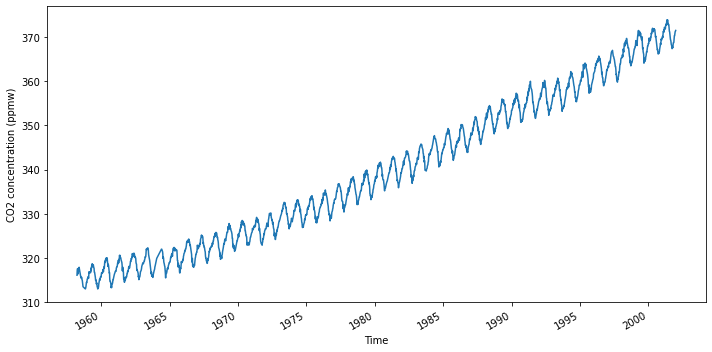

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Q['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')
fig.autofmt_xdate()
plt.tight_layout()

Se separan los datos en entrenamiento y testeo. Se dividen los datos en nplits grupos y se toma un grupo para testeo y el resto para entrenamiento.


In [4]:
s=round(len(Q)*0.80)
train=Q[:s]
test=Q[s:]  
print('El entrenamiento tiene:', train.shape[0])
print('El testeo tiene:', test.shape[0])

El entrenamiento tiene: 1827
El testeo tiene: 457


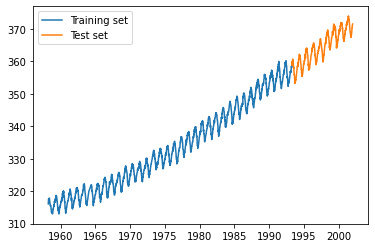

In [5]:
plt.plot(train)
plt.plot(test)
plt.legend(['Training set','Test set'])
plt.show()

## Scaling

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))

train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

In [8]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)


n_past is the number of step we will look in the past to predict the next target value.

In [10]:
n_past=7
trainX,trainY=createXY(train_scaled,n_past)
testX,testY=createXY(test_scaled,n_past)
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

trainX Shape--  (1820, 7, 1)
trainY Shape--  (1820,)
testX Shape--  (450, 7, 1)
testY Shape--  (450,)


## Multilayer Perceptron (MLP)

In [11]:
mlp_model = Sequential()
mlp_model.add(Dense(100, activation='relu', input_dim=trainX.shape[1]))
mlp_model.add(Dense(100,activation='sigmoid'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(1,activation='relu'))
mlp_model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               800       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,001
Trainable params: 11,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
mlp_model.fit(trainX,trainY, epochs=50, batch_size=50, validation_split=0.2)

Epoch 1/50
30/30 [==============================] - 2s 25ms/step - loss: 0.0897 - val_loss: 0.0366
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.0650 - val_loss: 0.0187
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0591 - val_loss: 0.0153
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0568 - val_loss: 0.0137
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0506 - val_loss: 0.0123
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0493 - val_loss: 0.0227
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0429 - val_loss: 0.0087
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0374 - val_loss: 0.0014
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0331 - val_loss: 0.0075
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0295 - val_loss: 0.0063
Epoch 11/50
30/30 

In [14]:
predY = mlp_model.predict(testX)

15/15 [==============================] - 0s 2ms/step


In [15]:
from sklearn.metrics import r2_score
r2_score(testY,predY)

0.8824703218293357

Text(0.5, 0, 'Day')

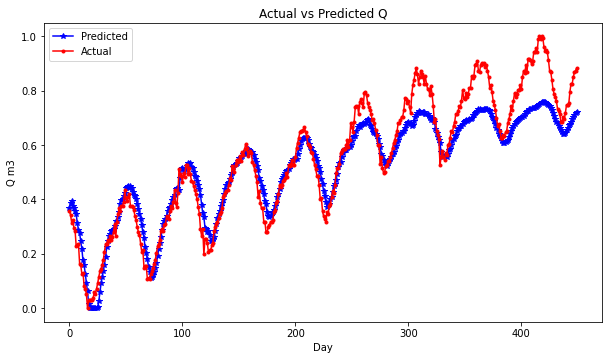

In [16]:
plt.figure(figsize=(10, 5.5))
plt.plot(predY,linestyle='-', marker='*',color='b')
plt.plot(pd.Series(testY).values,linestyle='-', marker='.',color='r')
plt.legend(['Predicted','Actual'], loc=2)
plt.title('Actual vs Predicted Q')
plt.ylabel('Q m3')
plt.xlabel('Day')

## LSTM

In [17]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape = (trainX.shape[1],1), return_sequences=True, activation ='relu'))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(50,activation='relu'))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(1))
lstm_model.compile(loss = 'mean_squared_error',optimizer = 'adam', metrics = ['mse'])

In [18]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 50)             10400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [19]:
lstm_model.fit(trainX, trainY, epochs=50, batch_size=10,validation_split=0.2)

Epoch 1/50
146/146 [==============================] - 5s 14ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 2/50
146/146 [==============================] - 2s 12ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 3/50
146/146 [==============================] - 2s 12ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 9.7304e-04 - val_mse: 9.7304e-04
Epoch 4/50
146/146 [==============================] - 2s 11ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 9.3471e-04 - val_mse: 9.3471e-04
Epoch 5/50
146/146 [==============================] - 2s 12ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 6/50
146/146 [==============================] - 2s 11ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 7/50
146/146 [==============================] - 2s 11ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/50
146/146 [==============================] -

In [20]:
predY = lstm_model.predict(testX)

15/15 [==============================] - 0s 4ms/step


In [21]:
r2_score(testY,predY)

0.9870544631274744

Text(0.5, 0, 'Day')

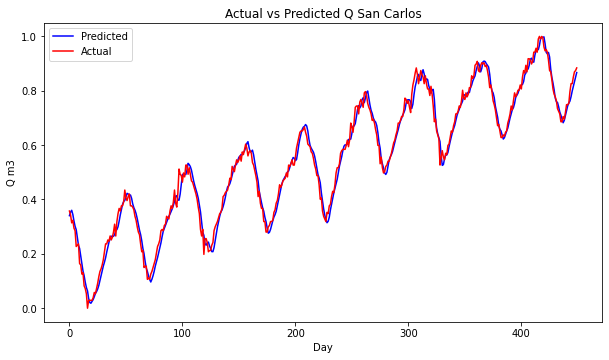

In [22]:
plt.figure(figsize=(10, 5.5))
plt.plot(predY,linestyle='-',color='b')
plt.plot(testY,linestyle='-',color='r')
plt.legend(['Predicted','Actual'], loc=2)
plt.title('Actual vs Predicted Q San Carlos')
plt.ylabel('Q m3')
plt.xlabel('Day')